# **Genetic Variants Conflict Prediction Using Machine Learning Algorithms**

## 1. Loading Libraries</a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set Matplotlib defaults
sns.set_style('darkgrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
#import tensorflow as tf

## 2. Import the dataset</a>

In [4]:
path = 'E:/Data Analytics/Projects/Projects/New folder (2)/New folder (2)/clinvar_conflicting.csv'
df = pd.read_csv(path)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


## 3. Explore the dataset</a>

In [5]:
df.shape

(65188, 46)

In [6]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing:np.nan'] = (df.isnull()).sum()
    summary_df['Missing:None'] = (df == "None").sum()
    summary_df['total'] =  summary_df['Missing:np.nan'] + summary_df['Missing:None']
    summary_df['Percent'] = 100*summary_df['total']/len(df)
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df.sort_values(ascending = False, by = 'Percent')

summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
MOTIF_SCORE_CHANGE,float64,65186,0,65186,99.996932,0,2,2
HIGH_INF_POS,object,65186,0,65186,99.996932,0,1,2
MOTIF_POS,float64,65186,0,65186,99.996932,0,1,2
MOTIF_NAME,object,65186,0,65186,99.996932,0,2,2
DISTANCE,float64,65080,0,65080,99.834325,0,96,108
SSR,float64,65058,0,65058,99.800577,0,2,130
CLNSIGINCL,object,65021,0,65021,99.743818,0,137,167
CLNDISDBINCL,object,65021,0,65021,99.743818,0,93,167
CLNDNINCL,object,65021,0,65021,99.743818,0,101,167
INTRON,object,56385,0,56385,86.495981,0,1929,8803


## 4. Data Preprocessing

### 4.1. Data Cleaning

In [7]:
# Identify columns with high Nan percentage
drop_cols =[cname for cname in df.columns if df[cname].isna().sum() >=  33219 ]
drop_cols

['CLNDISDBINCL',
 'CLNDNINCL',
 'CLNSIGINCL',
 'CLNVI',
 'SSR',
 'INTRON',
 'DISTANCE',
 'BAM_EDIT',
 'SIFT',
 'PolyPhen',
 'MOTIF_NAME',
 'MOTIF_POS',
 'HIGH_INF_POS',
 'MOTIF_SCORE_CHANGE',
 'BLOSUM62']

In [8]:
df.drop(drop_cols, axis =1, inplace = True)

In [9]:
df.dropna(axis = 0, inplace = True)

In [10]:
df.shape

(50248, 31)

In [12]:
summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
CHROM,object,0,0,0,0.000000,0,37,50248
IMPACT,object,0,0,0,0.000000,0,3,50248
CADD_PHRED,float64,0,0,0,0.000000,0,7699,50248
LoFtool,float64,0,0,0,0.000000,0,1181,50248
STRAND,float64,0,0,0,0.000000,0,2,50248
Codons,object,0,0,0,0.000000,0,1285,50248
Amino_acids,object,0,0,0,0.000000,0,581,50248
Protein_position,object,0,0,0,0.000000,0,6608,50248
CDS_position,object,0,0,0,0.000000,0,12261,50248
cDNA_position,object,0,0,0,0.000000,0,12453,50248


## 5. Exploratory Data Analysis

#### Distribution of the target

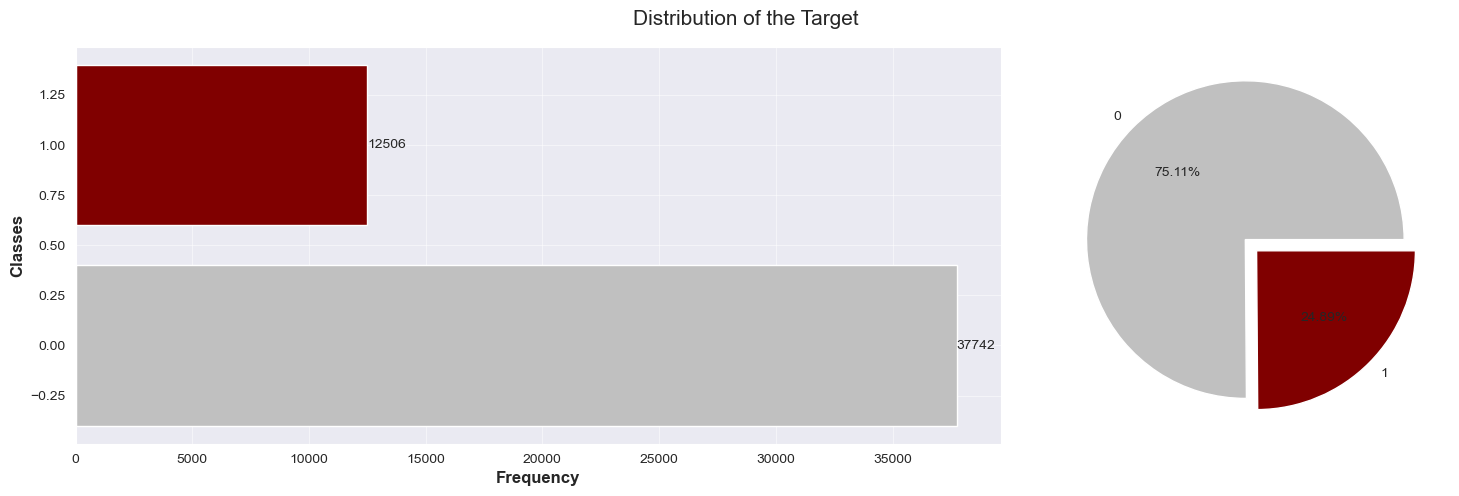

In [14]:
y = df['CLASS'].value_counts()
colors = colors = [ "Silver" ,"maroon"]
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})


axes[0].barh(y=y.index, width=y.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Classes')
axes[0].grid(alpha=0.5)
for index, values in enumerate(y):
    axes[0].text(values+1, index, str(values), va='center')

axes[1].pie(y.values, labels=y.index, autopct='%.2f%%', explode=([0.05]*len(y.index)), colors=colors)



figure.suptitle('Distribution of the Target', fontsize=15)
plt.tight_layout(pad=1)
plt.savefig('E:/Data Analytics/Projects/Projects/New folder (2)\Draft/Target.jpg')


In [15]:
# define categoric and numerical columns
categorical_variables = [col for col in df.columns if df[col].nunique() < 10 and
                        df[col].dtype == "object"]
numeric_variables = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

High_cardinality_variables = [col for col in df.columns if df[col].nunique() > 200 and
                        df[col].dtype == "object"]
df_uniques = df.nunique()
univariate = list(df_uniques[df_uniques == 1].index)

print("Categorical variables:", categorical_variables)
print("="*150)
print("Numeric variables:", numeric_variables)
print("="*150)
print("High cardinality  variables:", High_cardinality_variables)
print("="*150)
print("Univariate variables:", univariate)

Categorical variables: ['CLNVC', 'IMPACT', 'Feature_type', 'BIOTYPE']
Numeric variables: ['POS', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'ORIGIN', 'CLASS', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW']
High cardinality  variables: ['REF', 'CLNDISDB', 'CLNDN', 'CLNHGVS', 'SYMBOL', 'Feature', 'EXON', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons']
Univariate variables: ['Feature_type', 'BIOTYPE']


In [16]:
df.drop(univariate, axis =1, inplace = True)

In [17]:
df.drop(High_cardinality_variables, axis =1, inplace = True)

In [18]:
df.shape

(50248, 17)

In [19]:
num_cols = df[numeric_variables]
num_cols.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
POS,50248.000000,79473595.698197,60471897.396568,193245.000000,32906584.250000,59926598.500000,117243826.500000,247607973.000000
AF_ESP,50248.000000,0.012646,0.053665,0.000000,0.000000,0.000000,0.001000,0.499000
AF_EXAC,50248.000000,0.012362,0.054783,0.000000,0.000000,0.000040,0.000930,0.499890
AF_TGP,50248.000000,0.012984,0.054705,0.000000,0.000000,0.000000,0.001200,0.499800
ORIGIN,50248.000000,1.363139,6.284533,0.000000,1.000000,1.000000,1.000000,513.000000
CLASS,50248.000000,0.248886,0.432372,0.000000,0.000000,0.000000,0.000000,1.000000
STRAND,50248.000000,0.003503,1.000004,-1.000000,-1.000000,1.000000,1.000000,1.000000
LoFtool,50248.000000,0.349137,0.363762,0.000069,0.023500,0.160000,0.732000,1.000000
CADD_PHRED,50248.000000,17.026348,10.943288,0.001000,8.708750,16.120000,25.000000,81.000000
CADD_RAW,50248.000000,2.873371,3.082360,-5.477391,0.681978,1.985858,4.925722,34.236720


### 4.2. Handling class impalace

#### Handling class impalace using majoraty class down sampling technique

In [20]:
df['CLASS'].value_counts()

CLASS
0    37742
1    12506
Name: count, dtype: int64

In [21]:
df_0 = df[df['CLASS']==0][:12506]
print("Shape: ", df_0.shape)
print("income classes values count: ", df_0['CLASS'].value_counts())

Shape:  (12506, 17)
income classes values count:  CLASS
0    12506
Name: count, dtype: int64


In [22]:
df_1 = df[df['CLASS'] == 1][:12506]
print("Shape: ", df_1.shape)
print("income classes values count: ", df_1['CLASS'].value_counts())

Shape:  (12506, 17)
income classes values count:  CLASS
1    12506
Name: count, dtype: int64


In [23]:
df = pd.concat([df_0, df_1], axis=0)

### 4.3. Spliting the data set

In [38]:
y = df["CLASS"]
X = df.drop("CLASS",axis=1)

In [39]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.33, random_state=1)

### 4.4. Feature Importance Analysis

In [24]:
discrete_features = X_train.dtypes == int

In [25]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X_train,y_train,discrete_features):
    mi_scores = mutual_info_classif(X_train,y_train,discrete_features =discrete_features )
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X_train.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
mi_scores =  make_mi_scores(X_train,y_train,discrete_features)
mi_scores

POS            0.687956
CHROM          0.239432
LoFtool        0.175622
AF_EXAC        0.091335
AF_TGP         0.086196
AF_ESP         0.077566
MC             0.017782
Consequence    0.014010
IMPACT         0.013418
CADD_RAW       0.010940
STRAND         0.008989
CADD_PHRED     0.006856
Allele         0.004361
ALT            0.004077
CLNVC          0.002601
ORIGIN         0.001628
Name: MI Scores, dtype: float64

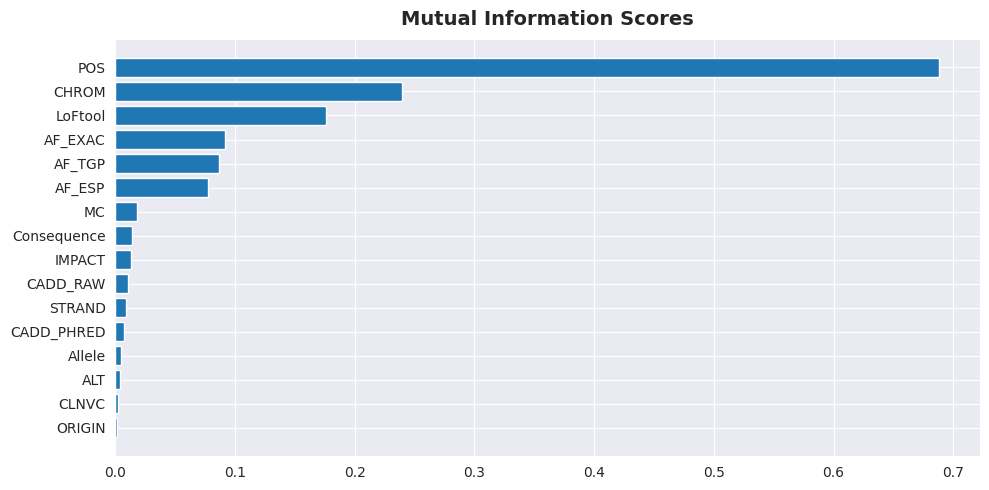

In [26]:
def plot_mi_scores(scores):
    fig, ax = plt.subplots(figsize=(10,5))
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plot_mi_scores(mi_scores)

### 4.5. Scaling

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 6. Modeling

####  Helper Fuctions

In [28]:
from sklearn import metrics
# calculating and plotting the confusion matrix
def plot_cm(y_tested,y_predicted):
    from mlxtend.plotting import plot_confusion_matrix
    cm1 = confusion_matrix(y_tested, y_predicted)
    plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
    plt.show()

def clf_plot(y_valid_test, y_pred) :
    cr = pd.DataFrame(metrics.classification_report(y_valid_test, y_pred, digits=3, output_dict=True)).T
    cr.drop(columns='support', inplace=True)
    plt.figure(figsize=(5,4))
    sns.heatmap(cr, annot=True, cmap='Blues',linecolor='white', linewidths=0.5)
    plt.title('Classification matrix')
    plt.tight_layout()
    plt.show()


def roc(model,y_pred,x_tested,y_tested):
    # Predict the probabilities of the positive class
    y_pred = model.predict_proba(x_tested)[:,1]
    y_pred.shape

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_tested, y_pred)

    # Calculate the AUC score
    auc_score = auc(fpr, tpr)
    x1=np.linspace(0,1,100)
    # Plot the ROC curve
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
    plt.plot(x1,x1,label='baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for binary classification")
    plt.legend()
    plt.show()

### 6.1. Random Forest Classifier

In [29]:
# RFC


from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=22, n_estimators=100, random_state=1).fit(X_train, y_train)
y_val_pred1 = rfc.predict(X_val)

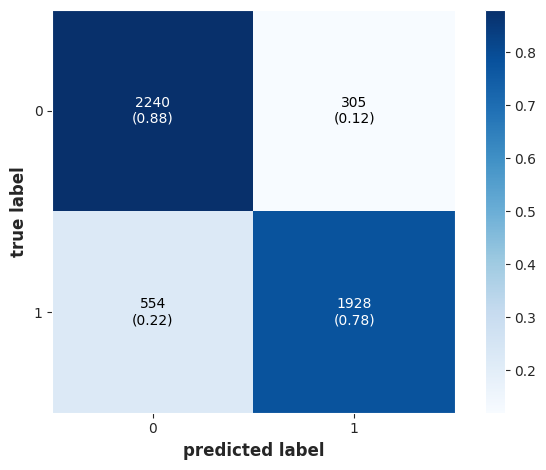

In [30]:
plot_cm(y_val,y_val_pred1)

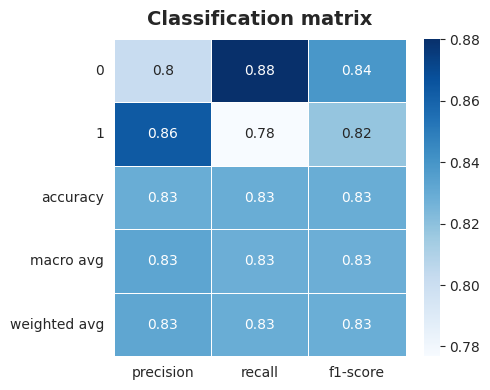

In [31]:
clf_plot(y_val, y_val_pred1)

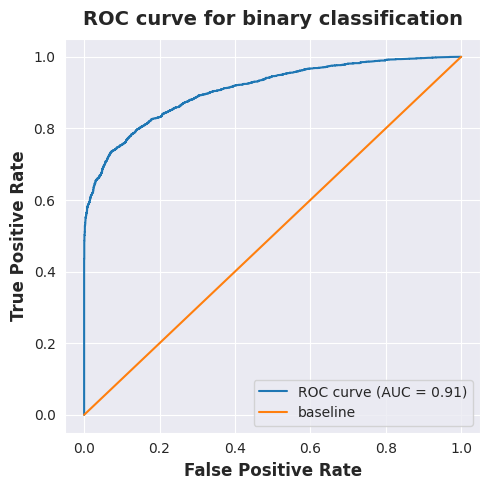

In [32]:
roc(rfc,y_val_pred1,X_val,y_val)

### 6.2 K-Neighbors Classifier

In [33]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)
y_val_pred2 = knn.predict(X_val)

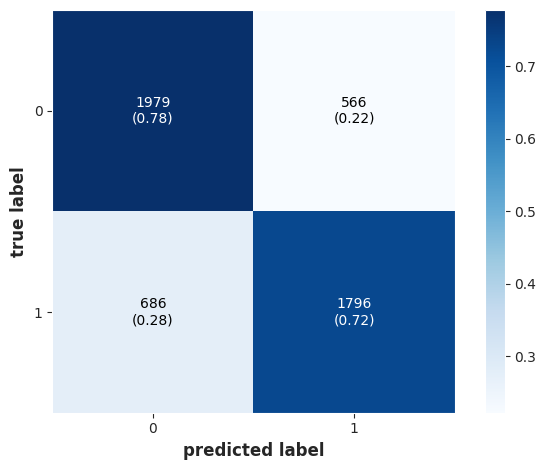

In [34]:
plot_cm(y_val,y_val_pred2)

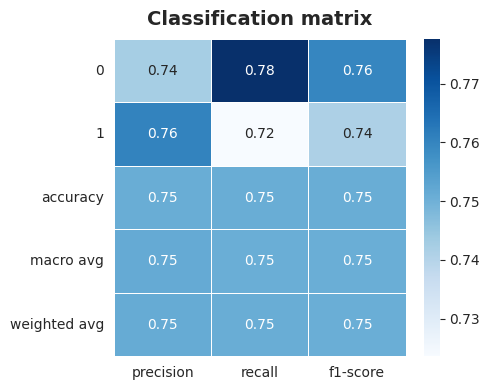

In [35]:
clf_plot(y_val, y_val_pred2)

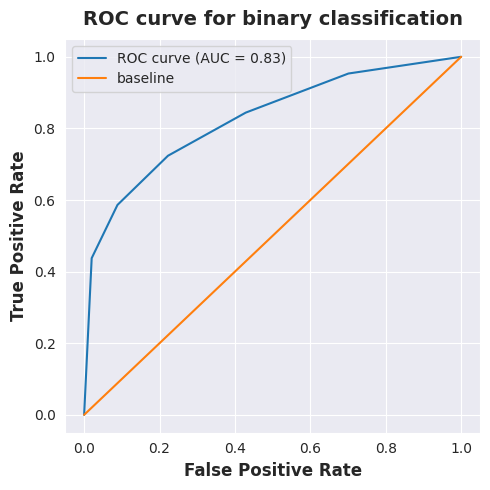

In [36]:
roc(knn,y_val_pred2,X_val,y_val)

### 6.3. Logistic Regression

In [37]:
# Train Log Regression
lr = LogisticRegression(max_iter=400).fit(X_train, y_train)
y_val_pred3 = lr.predict(X_val)


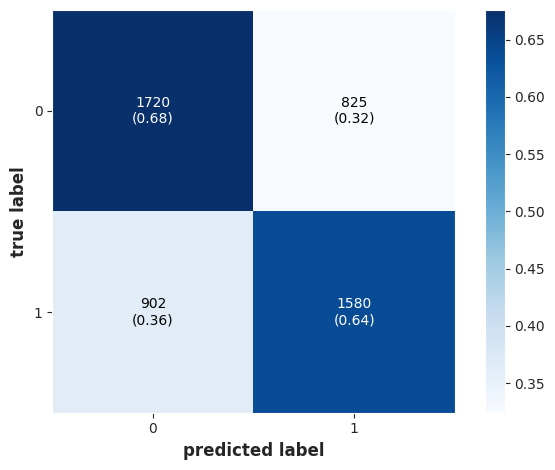

In [38]:
plot_cm(y_val,y_val_pred3)

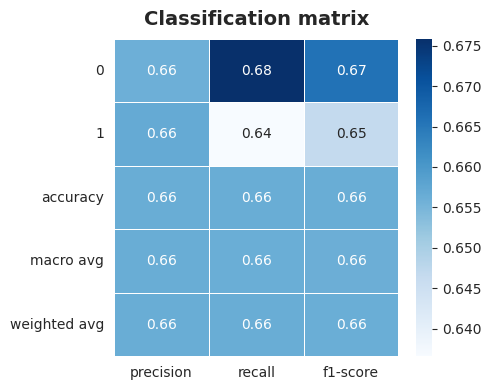

In [39]:
clf_plot(y_val, y_val_pred3)

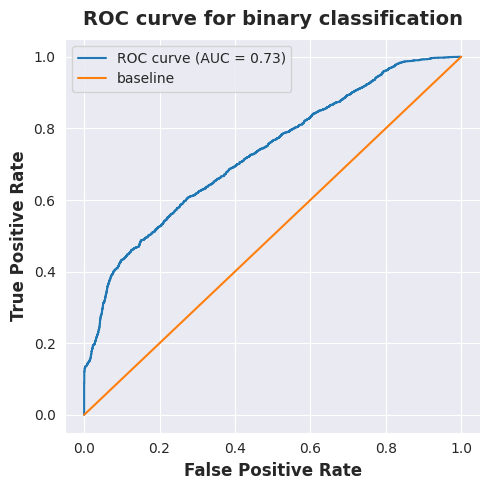

In [40]:
roc(lr,y_val_pred3,X_val,y_val)

### 6.4. Gaussian NB

In [41]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_val_pred4 =model.predict(X_val)

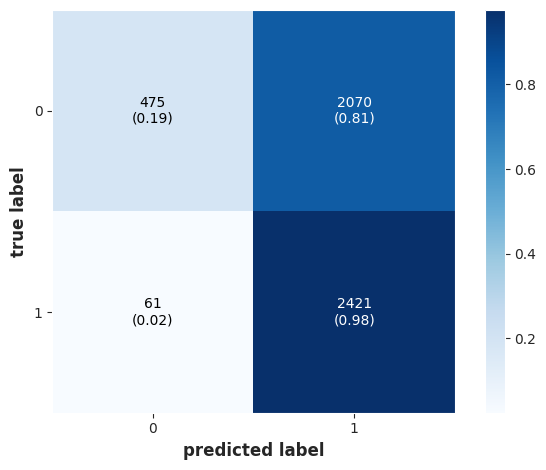

In [42]:
plot_cm(y_val,y_val_pred4)

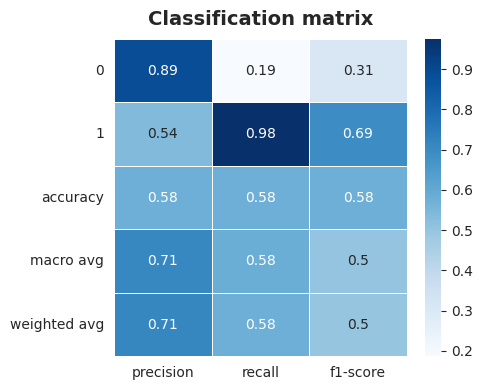

In [43]:
clf_plot(y_val, y_val_pred4)

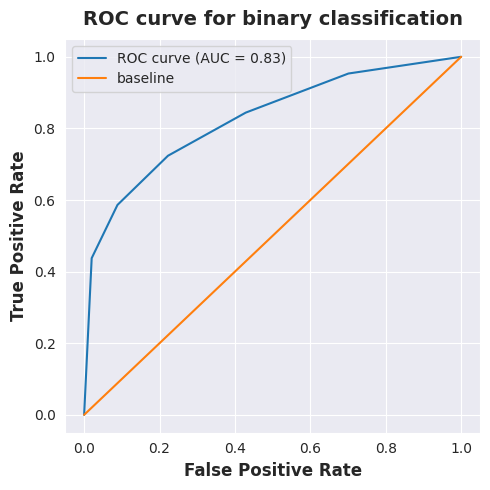

In [44]:
roc(knn,y_val_pred4,X_val,y_val)

### 6.5. AdaBoost Classifier

In [45]:
#AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
AdaBoost = AdaBoostClassifier(random_state=42).fit(X_train, y_train)
y_val_pred5 = AdaBoost.predict(X_val)

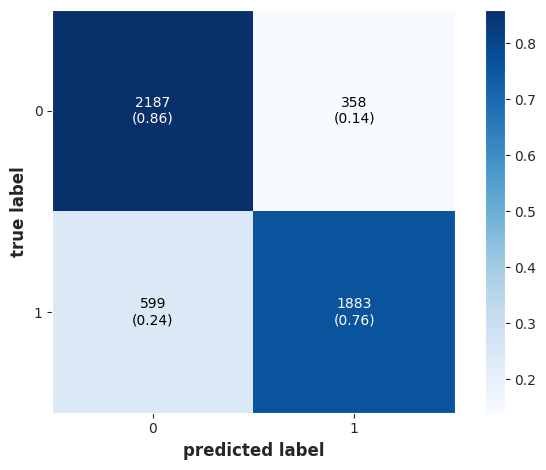

In [46]:
plot_cm(y_val,y_val_pred5)

In [47]:
print(classification_report(y_val, y_val_pred5))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2545
           1       0.84      0.76      0.80      2482

    accuracy                           0.81      5027
   macro avg       0.81      0.81      0.81      5027
weighted avg       0.81      0.81      0.81      5027



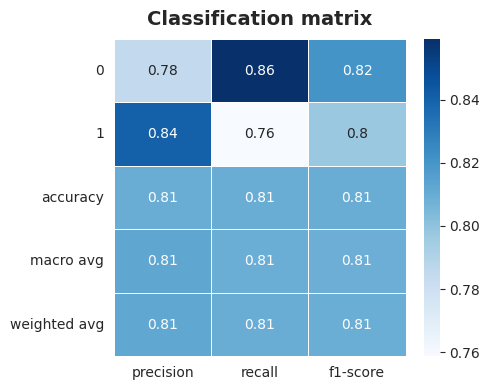

In [48]:
clf_plot(y_val, y_val_pred5)

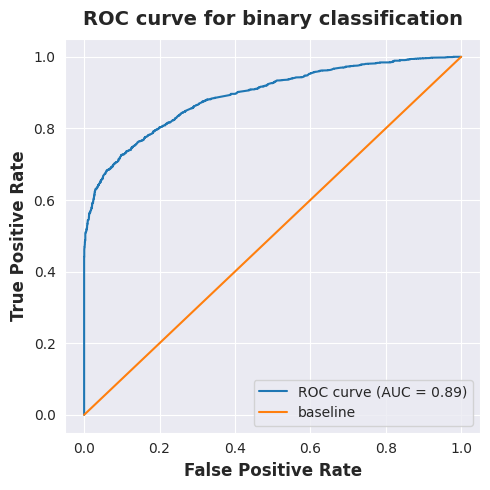

In [49]:
roc(AdaBoost,y_val_pred5,X_val,y_val)

### 6.6 Gradient Boosting Classifier

In [50]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
Gradien_Boosting = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
y_val_pred6 = Gradien_Boosting.predict(X_val)

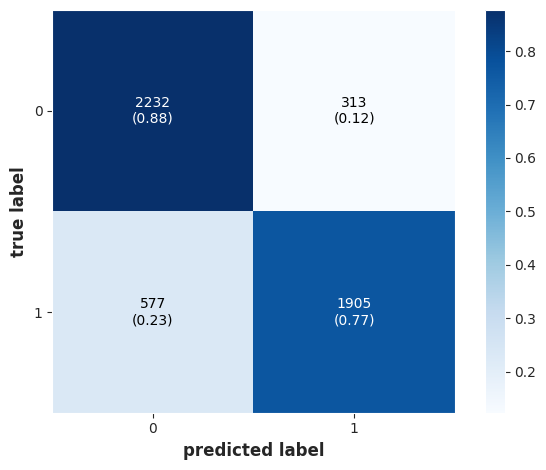

In [51]:
plot_cm(y_val,y_val_pred6)

In [52]:
print(classification_report(y_val, y_val_pred6))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      2545
           1       0.86      0.77      0.81      2482

    accuracy                           0.82      5027
   macro avg       0.83      0.82      0.82      5027
weighted avg       0.83      0.82      0.82      5027



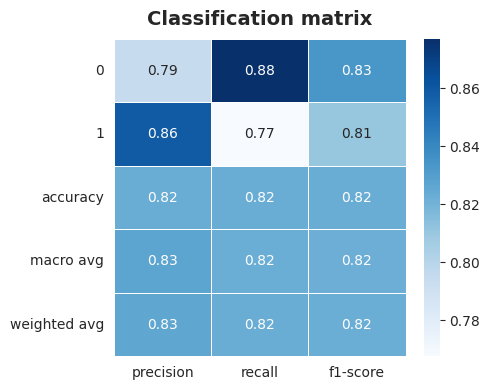

In [53]:
clf_plot(y_val, y_val_pred6)

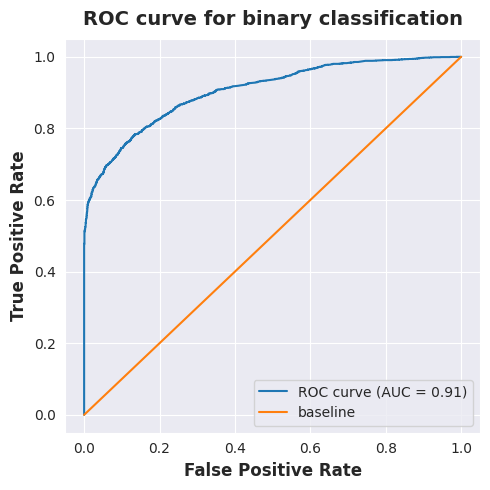

In [54]:
roc(Gradien_Boosting,y_val_pred6,X_val,y_val)

### 6.7 Extra Trees Classifier

In [55]:
from sklearn.ensemble import ExtraTreesClassifier
Extra_Trees = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)
y_val_pred7 = Extra_Trees.predict(X_val)

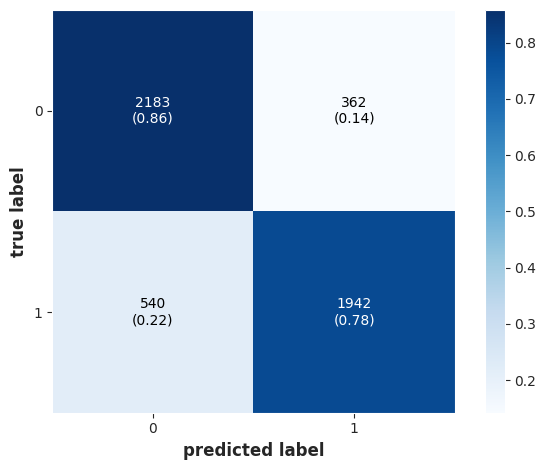

In [56]:
plot_cm(y_val,y_val_pred7)

In [57]:
print(classification_report(y_val, y_val_pred7))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2545
           1       0.84      0.78      0.81      2482

    accuracy                           0.82      5027
   macro avg       0.82      0.82      0.82      5027
weighted avg       0.82      0.82      0.82      5027



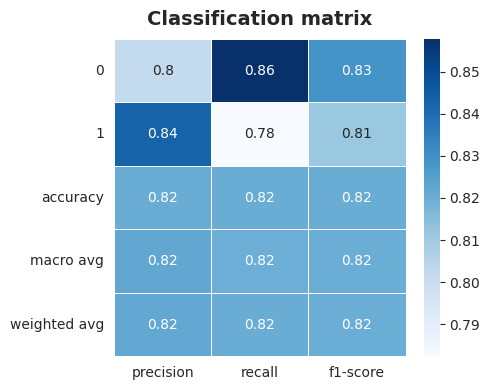

In [58]:
clf_plot(y_val, y_val_pred7)

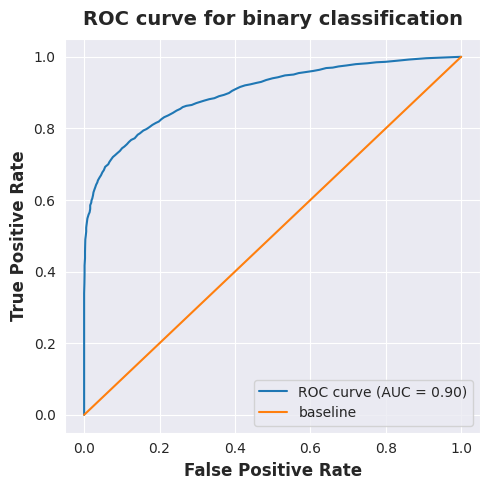

In [59]:
roc(Extra_Trees,y_val_pred7,X_val,y_val)

### 6.8. Bagging Classifier

In [60]:
from sklearn.ensemble import BaggingClassifier
Bagging_Classifier = BaggingClassifier(random_state=42).fit(X_train, y_train)
y_val_pred8 = Bagging_Classifier.predict(X_val)

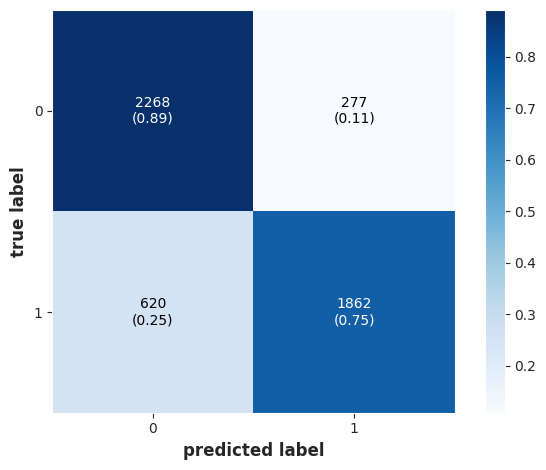

In [61]:
plot_cm(y_val,y_val_pred8)

In [62]:
print(classification_report(y_val, y_val_pred8))

              precision    recall  f1-score   support

           0       0.79      0.89      0.83      2545
           1       0.87      0.75      0.81      2482

    accuracy                           0.82      5027
   macro avg       0.83      0.82      0.82      5027
weighted avg       0.83      0.82      0.82      5027



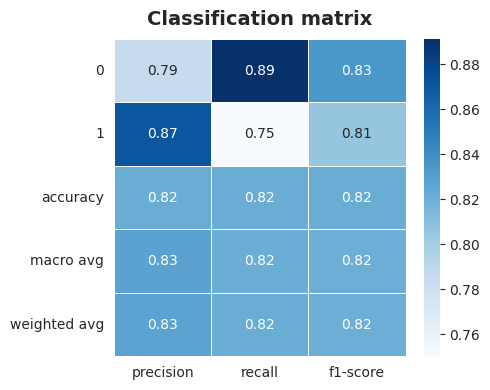

In [63]:
clf_plot(y_val, y_val_pred8)

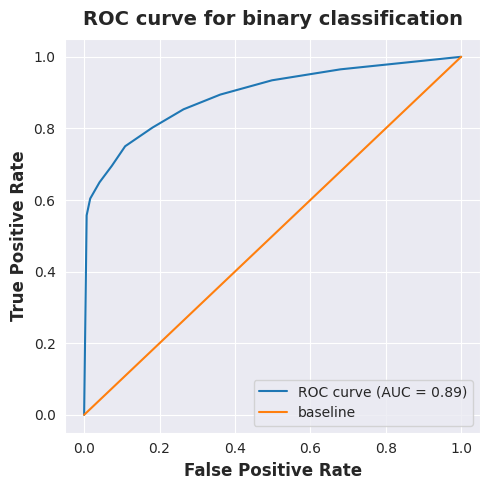

In [64]:
roc(Bagging_Classifier,y_val_pred8,X_val,y_val)

### 6.9. MLP Classifier

In [65]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(random_state=42).fit(X_train, y_train)
y_val_pred9 = MLP.predict(X_val)

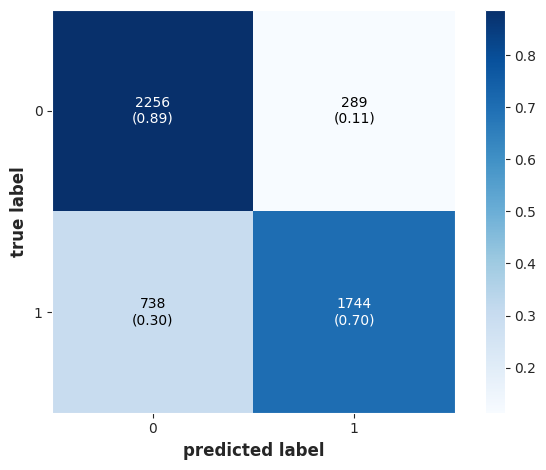

In [66]:
plot_cm(y_val,y_val_pred9)

In [67]:
print(classification_report(y_val, y_val_pred9))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      2545
           1       0.86      0.70      0.77      2482

    accuracy                           0.80      5027
   macro avg       0.81      0.79      0.79      5027
weighted avg       0.81      0.80      0.79      5027



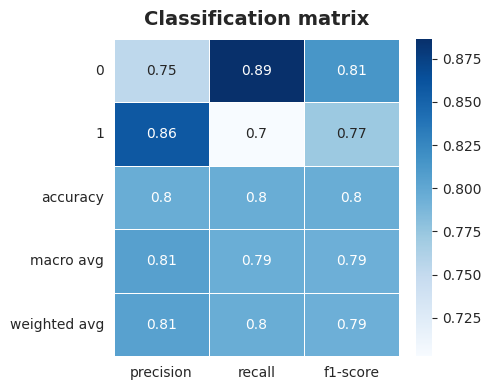

In [68]:
clf_plot(y_val, y_val_pred9)

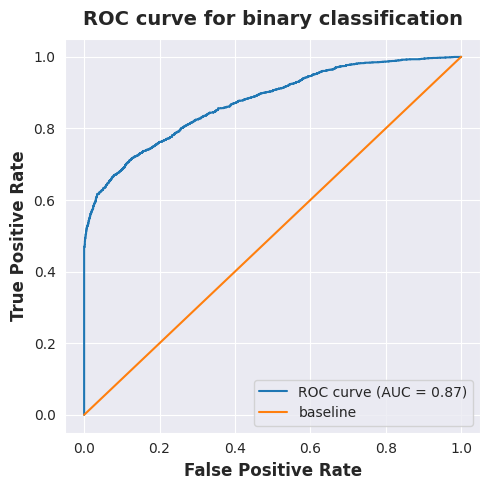

In [69]:
roc(MLP,y_val_pred9,X_val,y_val)

### 6.10 XGB Classifier

In [70]:
from xgboost import XGBClassifier
xgb= XGBClassifier(max_depth=20)
xgb.fit(X_train, y_train)
y_val_pred10 = xgb.predict(X_val)

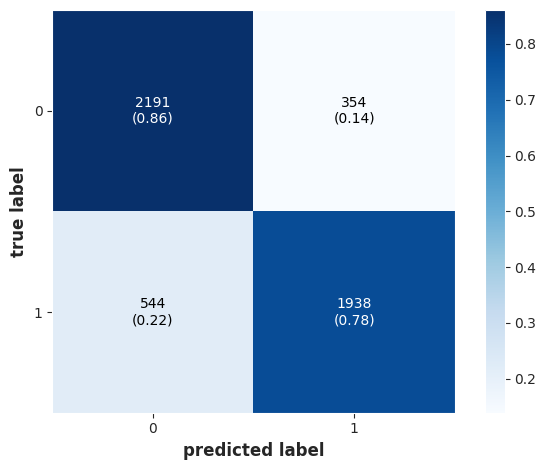

In [71]:
plot_cm(y_val,y_val_pred10)

In [72]:
print(classification_report(y_val, y_val_pred10))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2545
           1       0.85      0.78      0.81      2482

    accuracy                           0.82      5027
   macro avg       0.82      0.82      0.82      5027
weighted avg       0.82      0.82      0.82      5027



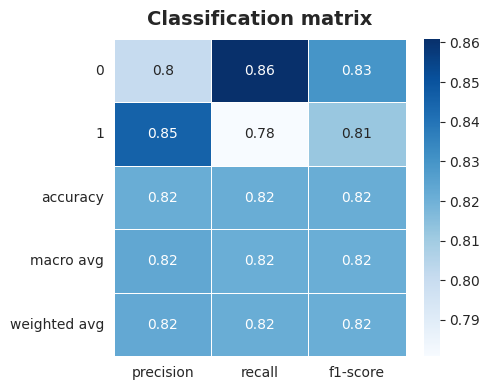

In [73]:
clf_plot(y_val, y_val_pred10)

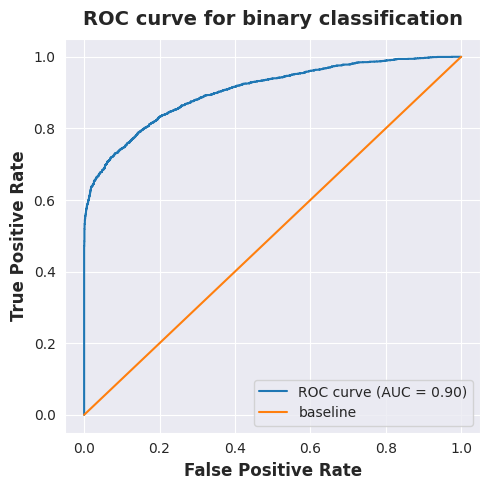

In [74]:
roc(xgb,y_val_pred10,X_val,y_val)

## 7. Comparing Models Performance

In [75]:
def measure_error(y_valid, y_val_pred, label):
    return pd.Series({"Accuracy": accuracy_score(y_valid, y_val_pred),
                     "Precision": precision_score(y_valid, y_val_pred),
                     "Recall": recall_score(y_valid, y_val_pred),
                     "F1": f1_score(y_valid, y_val_pred),
                     "AUROC": roc_auc_score(y_valid, y_val_pred)},
                     name = label)

In [76]:
RFC = pd.concat([measure_error(y_val, y_val_pred1,"RFC")],axis = 1)
KNN = pd.concat([measure_error(y_val, y_val_pred2,"KNN")],axis = 1)
Log_reg = pd.concat([measure_error(y_val, y_val_pred3,"Log_reg")],axis = 1)
GaussianNB = pd.concat([measure_error(y_val, y_val_pred4,"GaussianNB")],axis = 1)
Ada = pd.concat([measure_error(y_val, y_val_pred5,"Ada")],axis = 1)
Gradient = pd.concat([measure_error(y_val, y_val_pred6,"Gradient")],axis = 1)
Extra = pd.concat([measure_error(y_val, y_val_pred7,"Extra")],axis = 1)
Bagging = pd.concat([measure_error(y_val, y_val_pred8,"Bagging")],axis = 1)
MLP = pd.concat([measure_error(y_val, y_val_pred9,"MLP")],axis = 1)
XGB = pd.concat([measure_error(y_val, y_val_pred10,"XGB")],axis = 1)

In [77]:
compare_models =  pd.concat([RFC,KNN,Log_reg,GaussianNB,Ada,Gradient,Extra,Bagging,MLP,XGB],axis =1)
compare_models.style.background_gradient(cmap='Blues')

,RFC,KNN,Log_reg,GaussianNB,Ada,Gradient,Extra,Bagging,MLP,XGB
Accuracy,0.829123,0.750945,0.656455,0.576089,0.809628,0.822956,0.820569,0.821564,0.795703,0.821365
Precision,0.863412,0.760373,0.656965,0.539078,0.840250,0.858882,0.842882,0.870500,0.857846,0.845550
Recall,0.776793,0.723610,0.636583,0.975423,0.758662,0.767526,0.782434,0.750201,0.702659,0.780822
F1,0.817815,0.741536,0.646613,0.694393,0.797375,0.810638,0.811534,0.805886,0.772536,0.811898
AUROC,0.828475,0.750607,0.656209,0.581032,0.808997,0.822270,0.820097,0.820680,0.794552,0.820863


In [78]:
X_train.shape

(17508, 16)

### 6.10. Artifitial Neural Networks (ANN)

In [80]:
#Imports Tensorflow and create a Sequential Model to add layer for the ANN
ann = tf.keras.models.Sequential()
#Input layer
ann.add(tf.keras.layers.Dense(units=500,input_dim=16,kernel_initializer='uniform',activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
#Hidden layer 1
ann.add(tf.keras.layers.Dense(units=200, kernel_initializer='uniform',activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
#Output layer
ann.add(tf.keras.layers.Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
print(ann.summary()) #for showing the structure and parameters
#Compiles the ANN using ADAM optimizer.
ann.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])
#Trains the ANN with 100 epochs.
history = ann.fit(X_train, y_train, batch_size = 64,validation_split=0.20, epochs = 250, shuffle=True)
#Saves model
ann.save('cervical_model.h5')
#Saves history into npy file
np.save('cervical_history.npy', history.history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 500)               8500      
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               100200    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 108901 (425.39 KB)
Trainable params: 108901 (425.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/2

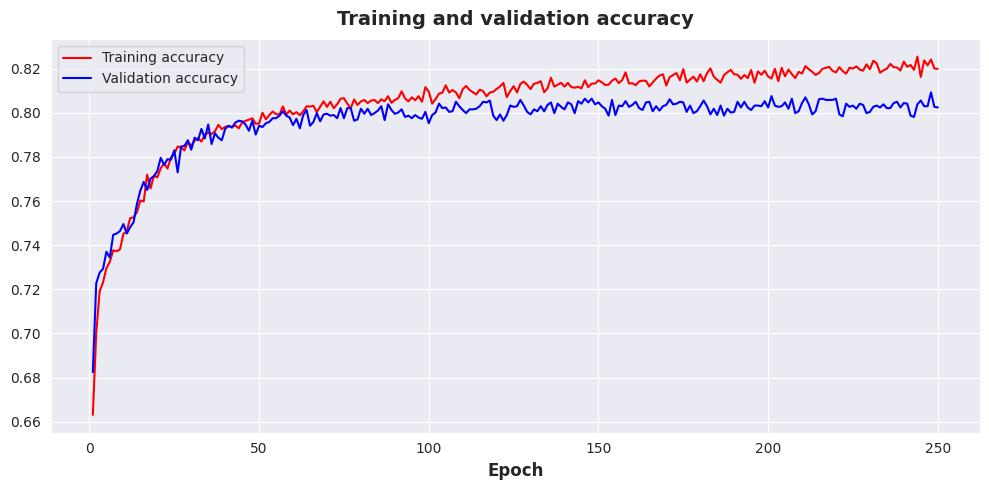

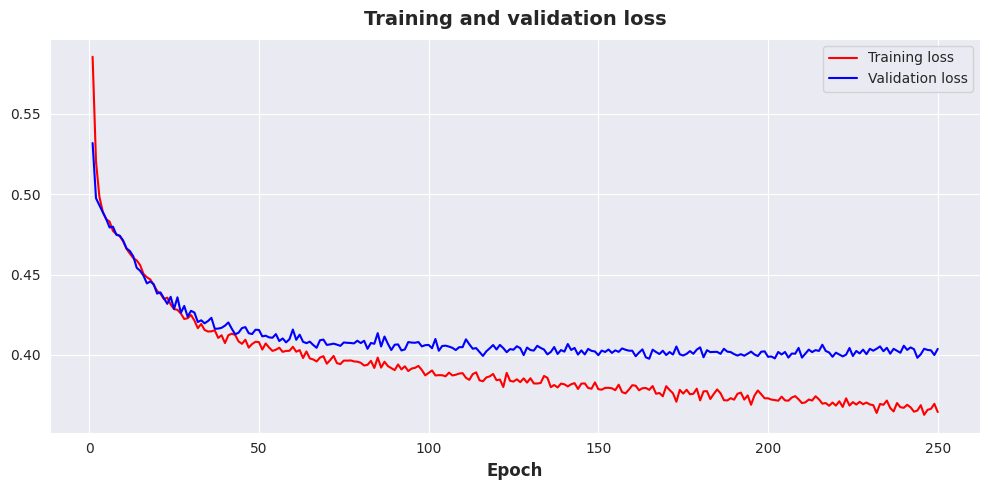

In [81]:
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy',)
plt.legend()
ax.set_xlabel("Epoch")
ax.tick_params()
plt.show()
#loss
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', )
plt.legend()
ax.set_xlabel("Epoch", )
ax.tick_params()
plt.show()

In [82]:
y_pred = ann.predict(X_val)
y_pred = [int(p>=0.5) for p in y_pred]
print(y_pred)

158/158 [==============================] - 0s 2ms/step
[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,

In [83]:
#Performance Evaluation - Accuracy and Classification Report
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(y_pred, y_val, normalize=True), '\n')
#precision, recall report
print ('Classification Report :\n\n' ,classification_report(y_pred, y_val))

Accuracy Score :  0.8054505669385319 

Classification Report :

               precision    recall  f1-score   support

           0       0.93      0.75      0.83      3161
           1       0.68      0.90      0.78      1866

    accuracy                           0.81      5027
   macro avg       0.80      0.83      0.80      5027
weighted avg       0.84      0.81      0.81      5027



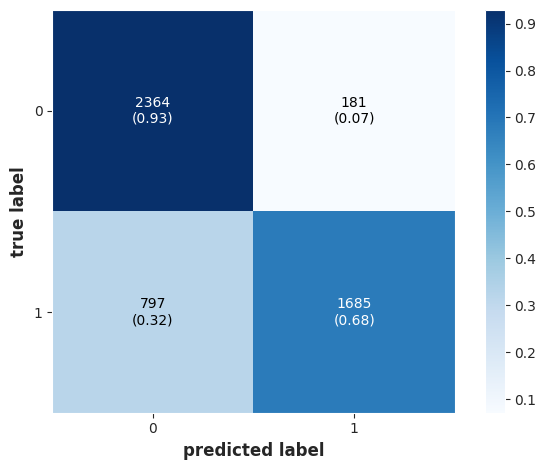

In [84]:
plot_cm(y_val,y_pred)

### 6.11 Long-Short Term Momory (LSTM)

In [85]:
# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1,X_test.shape[1])
# Create an LSTM model
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(units=1,activation='sigmoid')
])
print(lstm_model.summary()) # Display the model summary
# Compile the LSTM model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the LSTM model
history = lstm_model.fit(X_train, y_train,
batch_size=64, validation_split=0.20, epochs=250,
shuffle=True)
# Save the LSTM model
lstm_model.save('cervical_lstm_model.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/250
219/219 [==============================] - 4s 8ms/step - loss: 0.6330 - accuracy: 0.6234 - val_loss: 0.5894 - val_accuracy: 0.6636
Epoch 2/250
219/219 [==============================] - 2s 7ms/step - loss: 0.5897 - accuracy: 0.6536 - val_loss: 0.5771 - val_accuracy

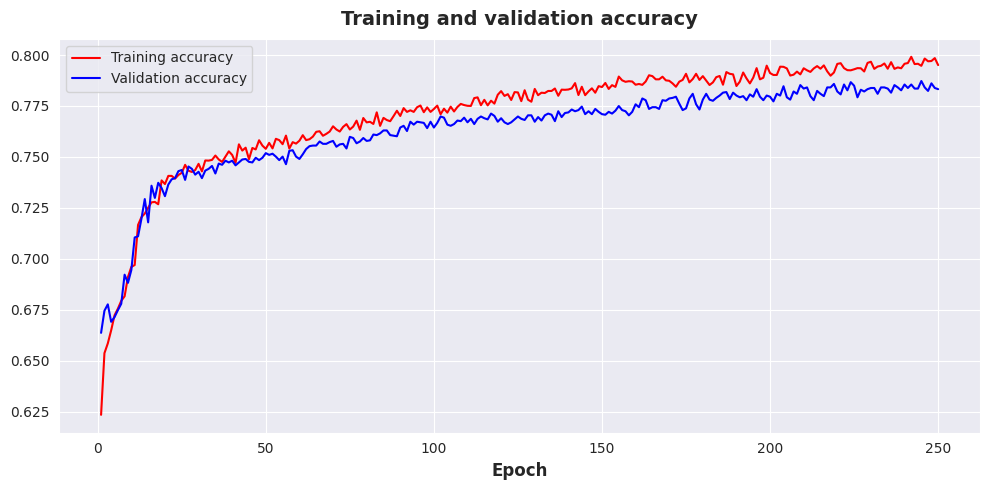

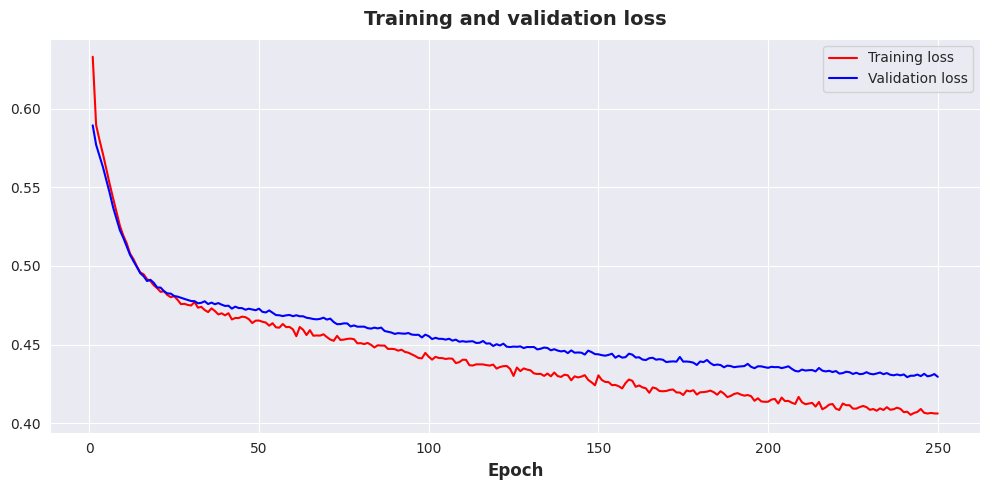

In [86]:
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy',)
plt.legend()
ax.set_xlabel("Epoch")
ax.tick_params()
plt.show()
#loss
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', )
plt.legend()
ax.set_xlabel("Epoch", )
ax.tick_params()
plt.show()

In [87]:
y_pred = lstm_model.predict(X_test)
y_pred = [int(p>=0.5) for p in y_pred]
print(y_pred)

78/78 [==============================] - 1s 2ms/step
[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1

In [88]:
#Performance Evaluation - Accuracy and Classification Report
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(y_pred, y_test, normalize=True), '\n')
#precision, recall report
print ('Classification Report :\n\n' ,classification_report(y_pred, y_test))

Accuracy Score :  0.7828017763423496 

Classification Report :

               precision    recall  f1-score   support

           0       0.87      0.75      0.80      1458
           1       0.70      0.84      0.76      1019

    accuracy                           0.78      2477
   macro avg       0.78      0.79      0.78      2477
weighted avg       0.80      0.78      0.78      2477



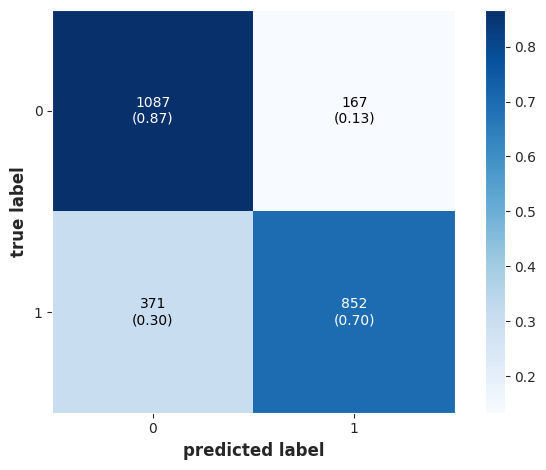

In [89]:
plot_cm(y_test,y_pred)

## Optimizing the Performace of the Best Model 

In [29]:
# create a Random Forest Classifier
forest = RandomForestClassifier(random_state=122)

# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(X_train, y_train)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best Accuracy: ', grid_search_forest.best_score_)

# get the best model
best_forest_selected = grid_search_forest.best_estimator_

Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy:  0.8305918142666588


In [30]:
y_test_pred = best_forest_selected.predict(X_test)

## Classification Report for validation set
p, r, _ = precision_recall_curve(y_test, y_test_pred)
print("Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')
print(f'Precision: {precision_score(y_test, y_test_pred)}')
print(f'Recall: {recall_score(y_test, y_test_pred)}')
print(f'F1-Score: {f1_score(y_test, y_test_pred)}')
print(f'AUROC: {roc_auc_score(y_test, y_test_pred)}')
print(f'AUPRC: {auc(p, r)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1254
           1       0.85      0.77      0.81      1223

    accuracy                           0.82      2477
   macro avg       0.83      0.82      0.82      2477
weighted avg       0.82      0.82      0.82      2477

Accuracy: 0.8219620508679855
Precision: 0.8541666666666666
Recall: 0.7710547833197057
F1-Score: 0.8104856037816931
AUROC: 0.8213328143073807
AUPRC: 0.37538827848531375


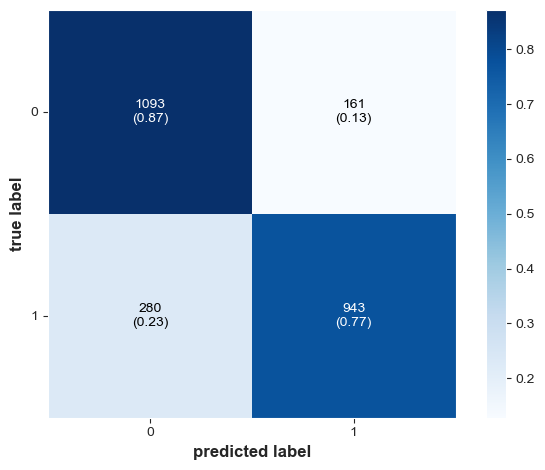

In [31]:
plot_cm(y_test,y_test_pred)

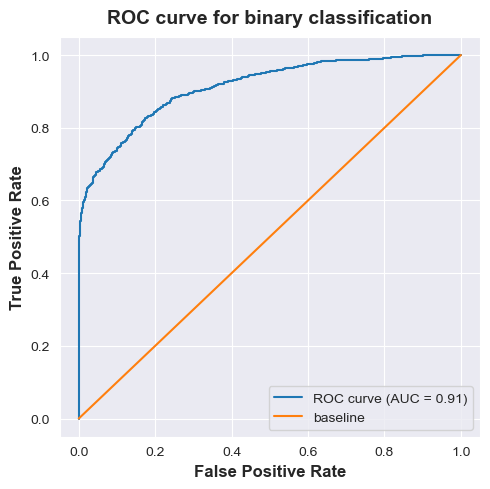

In [35]:
roc(best_forest_selected,y_test_pred,X_test,y_test)

In [42]:
scores= best_forest_selected.feature_importances_
scores = pd.DataFrame(scores)
df_columns = pd.DataFrame(X_train.columns)

In [43]:
f_Scores = pd.concat([df_columns,scores],axis=1)               # feature scores
f_Scores.columns = ['Feature','Score']
f_Scores = f_Scores.nlargest(20,'Score')
f_Scores

,Feature,Score
0,CHROM,0.381490
4,AF_EXAC,0.109957
1,POS,0.092805
5,AF_TGP,0.081076
13,LoFtool,0.080690
3,AF_ESP,0.064925
15,CADD_RAW,0.060721
14,CADD_PHRED,0.052385
7,MC,0.014513
2,ALT,0.013244


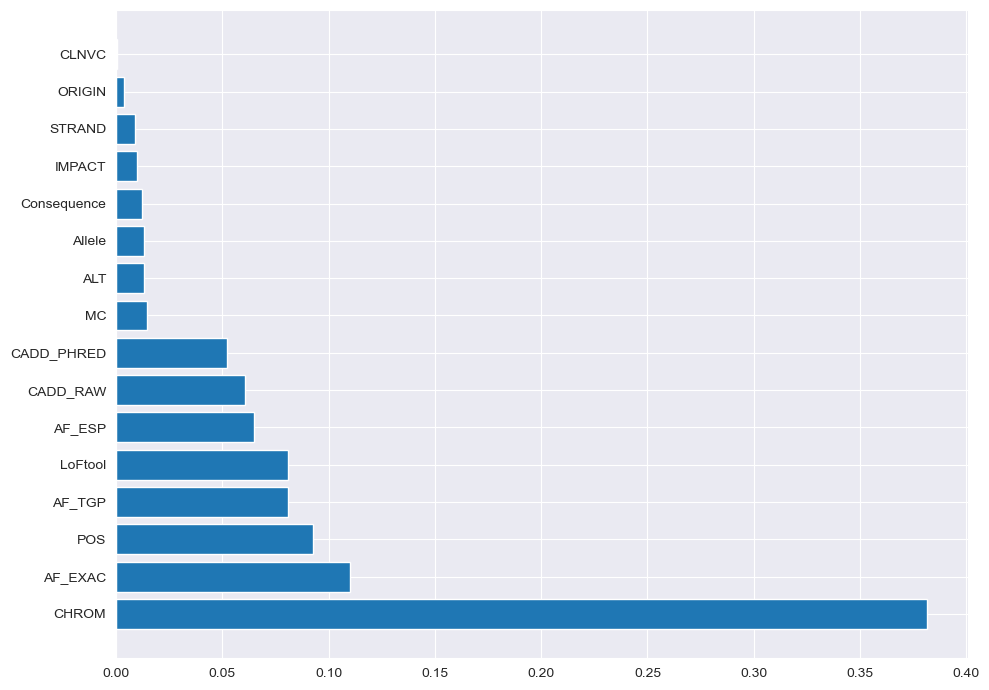

In [44]:
x = np.array(f_Scores["Feature"])
y = np.array(f_Scores["Score"])
plt.figure(figsize=(10, 7))
plt.barh(x,y, height = 0.8)
plt.show()